In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_rel

In [2]:
pos_tags = [
        'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
        'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT','SCONJ', 'SYM', 'VERB', 'X'
    ]
storys=['story1','story2','story3','story4','story5','SecretLifeWalterMitty']
seg_cond=['seg','noseg']

In [3]:
result_path = './attention_event/results/'  

In [4]:
plot_dir = './attention_event/plots/'

# Ensure the plot directory exists
os.makedirs(plot_dir, exist_ok=True)

## Load and sort attention score for each POS tag

In [5]:
# Initialize a dictionary to store the final averaged results
final_results_layer_ave = {}
final_results_all_attention = {}

In [6]:
# Iterate over each POS tag and segmentation condition
for pos_tag in pos_tags:
    for cond in seg_cond:
        story_count = 0
        accumulated_layer_ave = None
        accumulated_all_attention = None

        # Iterate over each story
        for story in storys:
            # Construct the file paths for layer averaged results and all attention values
            layer_ave_path = os.path.join(result_path, f'{story}_{cond}', f'{pos_tag}_attention_layer.npy')
            all_attention_path = os.path.join(result_path, f'{story}_{cond}', f'{pos_tag}_attention_all.npy')

            # Check if the files exist
            if os.path.exists(layer_ave_path) and os.path.exists(all_attention_path):
                # Load the files
                layer_ave = np.load(layer_ave_path)
                all_attention = np.load(all_attention_path)

                # Check if the loaded arrays are not empty
                if layer_ave.size > 0 and all_attention.size > 0:
                    # Initialize accumulation arrays if they are None
                    if accumulated_layer_ave is None:
                        accumulated_layer_ave = np.zeros_like(layer_ave)
                    if accumulated_all_attention is None:
                        accumulated_all_attention = np.zeros_like(all_attention)

                    # Accumulate the results
                    accumulated_layer_ave += layer_ave
                    accumulated_all_attention += all_attention
                    story_count += 1

        # If there were stories that detected the POS tag, average the results
        if story_count > 0:
            final_results_layer_ave[(pos_tag, cond)] = accumulated_layer_ave / story_count
            final_results_all_attention[(pos_tag, cond)] = accumulated_all_attention / story_count
        else:
            print(f"No stories detected {pos_tag} in condition {cond}.")


No stories detected CCONJ in condition seg.
No stories detected CCONJ in condition noseg.
No stories detected SYM in condition seg.
No stories detected SYM in condition noseg.
No stories detected X in condition seg.
No stories detected X in condition noseg.


## 3.1 Attention output across layers and attention heads: Stats, and Table in A.3

In [9]:
import numpy as np
import os
from scipy.stats import ttest_rel

# Initialize a dictionary to store the results for each POS tag
layer_head_diff = {}

# Iterate over each POS tag
for pos_tag in pos_tags:
    story_count = 0
    accumulated_seg = None
    accumulated_noseg = None

    # Iterate over each story
    for story in storys:
        # Load the attention data for each layer and head for seg and noseg
        seg_path = os.path.join(result_path, f'{story}_seg', f'{pos_tag}_attention_all.npy')
        noseg_path = os.path.join(result_path, f'{story}_noseg', f'{pos_tag}_attention_all.npy')

        if os.path.exists(seg_path) and os.path.exists(noseg_path):
            seg_attention = np.load(seg_path)  # Shape: (layers, heads)
            noseg_attention = np.load(noseg_path)  # Shape: (layers, heads)

            if seg_attention.size > 0 and noseg_attention.size > 0:
                # Initialize accumulation arrays if they are None
                if accumulated_seg is None:
                    accumulated_seg = np.zeros_like(seg_attention)
                if accumulated_noseg is None:
                    accumulated_noseg = np.zeros_like(noseg_attention)

                # Accumulate the results across stories
                accumulated_seg += seg_attention
                accumulated_noseg += noseg_attention
                story_count += 1

    # If there were stories that detected the POS tag, average the results
    if story_count > 0:
        avg_seg_attention = accumulated_seg / story_count
        avg_noseg_attention = accumulated_noseg / story_count

        # Flatten the averaged attention matrices
        seg_flattened = avg_seg_attention.flatten()
        noseg_flattened = avg_noseg_attention.flatten()

        # Perform a single paired t-test on the flattened data
        t_stat, p_value = ttest_rel(seg_flattened, noseg_flattened)

        # Store the t-test results for this POS tag
        layer_head_diff[pos_tag] = {
            't_stat': t_stat,
            'p_value': p_value
        }

        # Print the t-test results for this POS tag
        print(f"{pos_tag} - t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    else:
        print(f"Not enough data to compare 'seg' and 'noseg' conditions for POS tag: {pos_tag}")


ADJ - t-statistic: 5.2170, p-value: 0.0000
ADP - t-statistic: 10.1629, p-value: 0.0000
ADV - t-statistic: 16.0100, p-value: 0.0000
AUX - t-statistic: 7.6384, p-value: 0.0000
Not enough data to compare 'seg' and 'noseg' conditions for POS tag: CCONJ
DET - t-statistic: 6.8127, p-value: 0.0000
INTJ - t-statistic: -4.6494, p-value: 0.0000
NOUN - t-statistic: 3.5597, p-value: 0.0004
NUM - t-statistic: -4.6788, p-value: 0.0000
PART - t-statistic: 3.3212, p-value: 0.0009
PRON - t-statistic: 3.9429, p-value: 0.0001
PROPN - t-statistic: -8.1706, p-value: 0.0000
PUNCT - t-statistic: 5.7519, p-value: 0.0000
SCONJ - t-statistic: 8.6492, p-value: 0.0000
Not enough data to compare 'seg' and 'noseg' conditions for POS tag: SYM
VERB - t-statistic: 11.9921, p-value: 0.0000
Not enough data to compare 'seg' and 'noseg' conditions for POS tag: X


## 3.2 Attention pattern across layers when averaging across attention heads: Stats Table

In [7]:
# Initialize dictionaries to store the results
layer_ave_diff = {}

# Iterate over each POS tag
for pos_tag in pos_tags:
    accumulated_seg = None
    accumulated_noseg = None
    story_count = 0

    # Iterate over each story
    for story in storys:
        # Load the averaged attention data for seg and noseg
        seg_path = os.path.join(result_path, f'{story}_seg', f'{pos_tag}_attention_layer.npy')
        noseg_path = os.path.join(result_path, f'{story}_noseg', f'{pos_tag}_attention_layer.npy')

        if os.path.exists(seg_path) and os.path.exists(noseg_path):
            seg_attention = np.load(seg_path)
            noseg_attention = np.load(noseg_path)

            if seg_attention.size > 0 and noseg_attention.size > 0:
                # Initialize accumulation arrays if they are None
                if accumulated_seg is None:
                    accumulated_seg = np.zeros_like(seg_attention)
                if accumulated_noseg is None:
                    accumulated_noseg = np.zeros_like(noseg_attention)

                # Accumulate the results
                accumulated_seg += seg_attention
                accumulated_noseg += noseg_attention
                story_count += 1

    # If there were stories that detected the POS tag, average the results
    if story_count > 0:
        avg_seg_attention = accumulated_seg / story_count
        avg_noseg_attention = accumulated_noseg / story_count

        # Flatten the arrays to perform a paired t-test or Wilcoxon signed-rank test
        seg_flattened = avg_seg_attention.flatten()
        noseg_flattened = avg_noseg_attention.flatten()

        # Perform a paired t-test
        t_stat, p_value = ttest_rel(seg_flattened, noseg_flattened)
        
        # Store the results
        layer_ave_diff[pos_tag] = {
            't_stat': t_stat,
            'p_value': p_value
        }
    else:
        print(f"Not enough data to compare 'seg' and 'noseg' conditions for POS tag: {pos_tag}")

# Example: Accessing the difference results
for pos_tag, stats in layer_ave_diff.items():
    print(f"{pos_tag} - t-statistic: {stats['t_stat']}, p-value: {stats['p_value']}")

Not enough data to compare 'seg' and 'noseg' conditions for POS tag: CCONJ
Not enough data to compare 'seg' and 'noseg' conditions for POS tag: SYM
Not enough data to compare 'seg' and 'noseg' conditions for POS tag: X
ADJ - t-statistic: 1.9889734723895007, p-value: 0.05559182026918949
ADP - t-statistic: 5.782683920263635, p-value: 2.2801976848738253e-06
ADV - t-statistic: 6.3247425987826364, p-value: 4.886941771874449e-07
AUX - t-statistic: 4.886768384298587, p-value: 2.970524491618711e-05
DET - t-statistic: 3.2278750771118885, p-value: 0.0029433423202067568
INTJ - t-statistic: -2.49436135513722, p-value: 0.018157916674883142
NOUN - t-statistic: 1.1752966906730662, p-value: 0.24882436138230887
NUM - t-statistic: -1.9952989366284588, p-value: 0.05486325838600253
PART - t-statistic: 1.5381996677015466, p-value: 0.1341456314824925
PRON - t-statistic: 1.86846757541687, p-value: 0.0711731699141577
PROPN - t-statistic: -2.651291122657426, p-value: 0.012518685742337566
PUNCT - t-statistic: 2

## 3.2 Attention pattern across layers: each layer’s averaged attention score: Stats

In [12]:
from scipy.stats import wilcoxon
import pandas as pd
# Directory to save CSV files
output_csv_dir = './attention_event/results/stats'  # Replace with your desired path
os.makedirs(output_csv_dir, exist_ok=True)

# Iterate over each POS tag
for pos_tag in pos_tags:
    results = []
    
    # Initialize lists to collect data across stories
    seg_measurements = []
    noseg_measurements = []

    # Collect data for each story
    for story in storys:
        # Load the attention data for each layer for seg and noseg
        seg_path = os.path.join(result_path, f'{story}_seg', f'{pos_tag}_attention_layer.npy')
        noseg_path = os.path.join(result_path, f'{story}_noseg', f'{pos_tag}_attention_layer.npy')

        if os.path.exists(seg_path) and os.path.exists(noseg_path):
            seg_attention = np.load(seg_path)  
            noseg_attention = np.load(noseg_path)  

            if seg_attention.size > 0 and noseg_attention.size > 0:
                seg_measurements.append(seg_attention)
                noseg_measurements.append(noseg_attention)

    # Convert lists to numpy arrays for easier processing
    seg_measurements = np.array(seg_measurements)  
    noseg_measurements = np.array(noseg_measurements)  

    # Perform the Wilcoxon signed-rank test for each layer if we have data for all stories
    if seg_measurements.shape[0] != 0 and noseg_measurements.shape[0] != 0:
        for layer in range(seg_measurements.shape[1]):  # Iterate over each layer
            # Perform the Wilcoxon signed-rank test
            stat, p_value = wilcoxon(seg_measurements[:, layer], noseg_measurements[:, layer])

            # Record the result as a dictionary
            results.append({
                'layer': layer,
                'n': seg_measurements.shape[0],  # Number of stories
                'stat': stat,
                'p_value': p_value
            })

            #print(f"POS tag: {pos_tag}, Layer: {layer} - Wilcoxon stat: {stat:.4f}, p-value: {p_value:.4f}")

        # Convert results to a DataFrame
        results_df = pd.DataFrame(results)

        # Save the DataFrame to a CSV file
        csv_filename = f'{pos_tag}_wilcoxon_results.csv'
        csv_filepath = os.path.join(output_csv_dir, csv_filename)
        results_df.to_csv(csv_filepath, index=False)
    else:
        print(f"Insufficient data for POS tag {pos_tag}. Skipping Wilcoxon test.")


Insufficient data for POS tag CCONJ. Skipping Wilcoxon test.
Insufficient data for POS tag SYM. Skipping Wilcoxon test.
Insufficient data for POS tag X. Skipping Wilcoxon test.


## A.2 Attention distribution for each POS tag: across all the layers: Figure

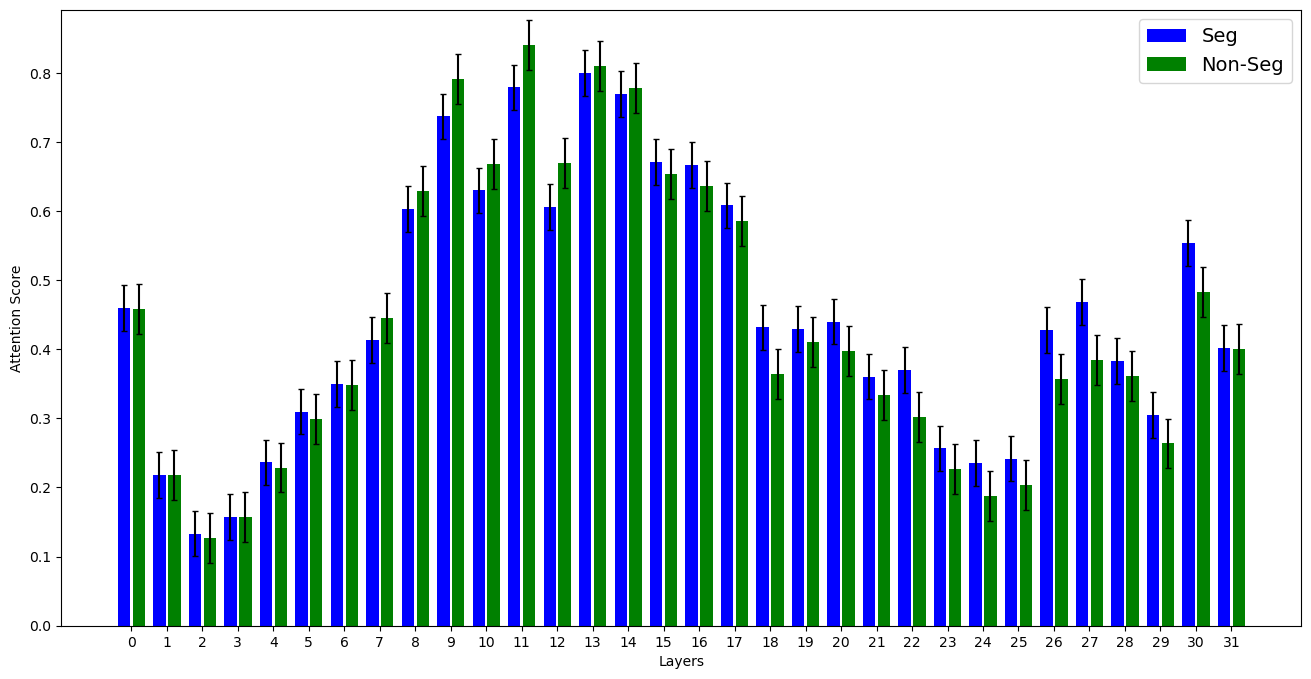

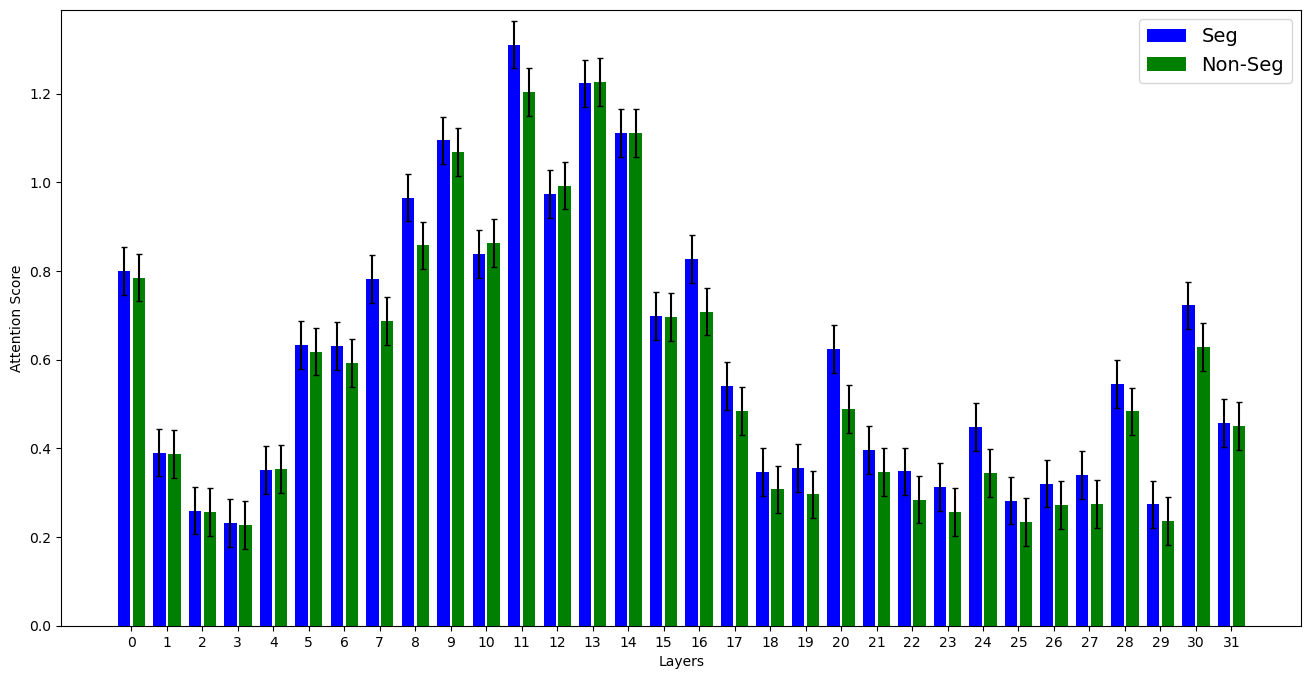

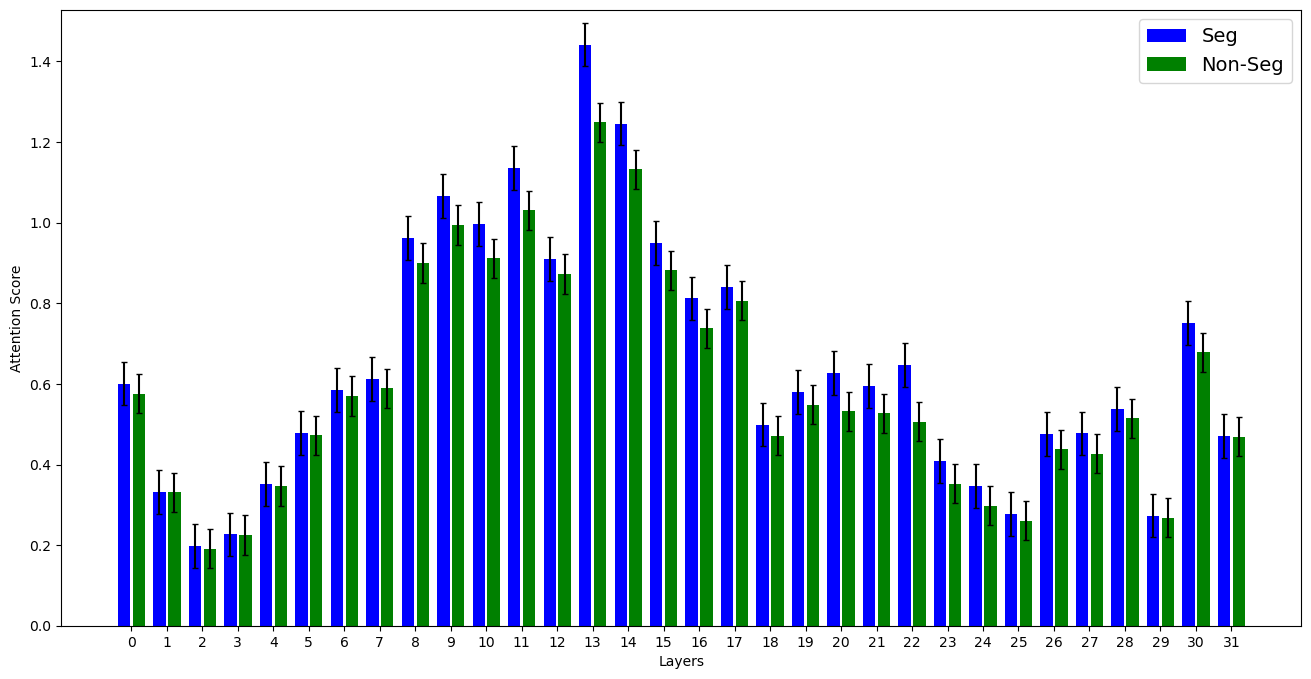

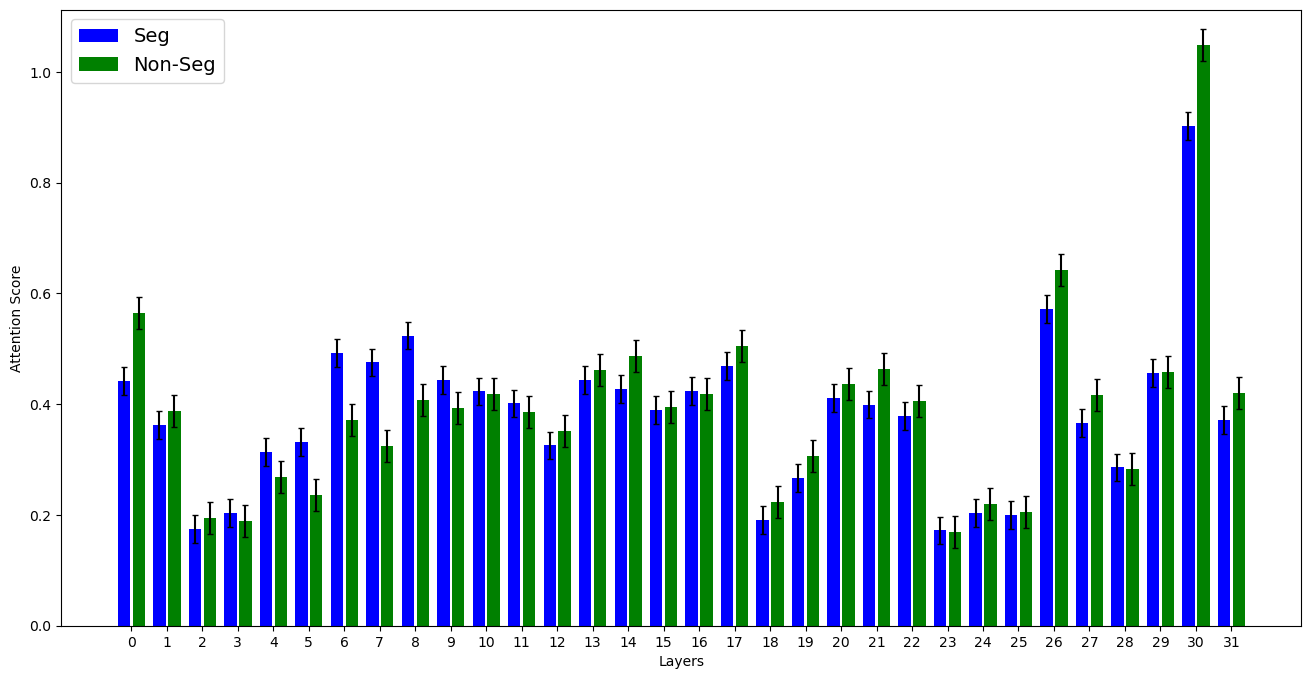

Data for POS tag CCONJ is missing for either 'seg' or 'noseg' condition.


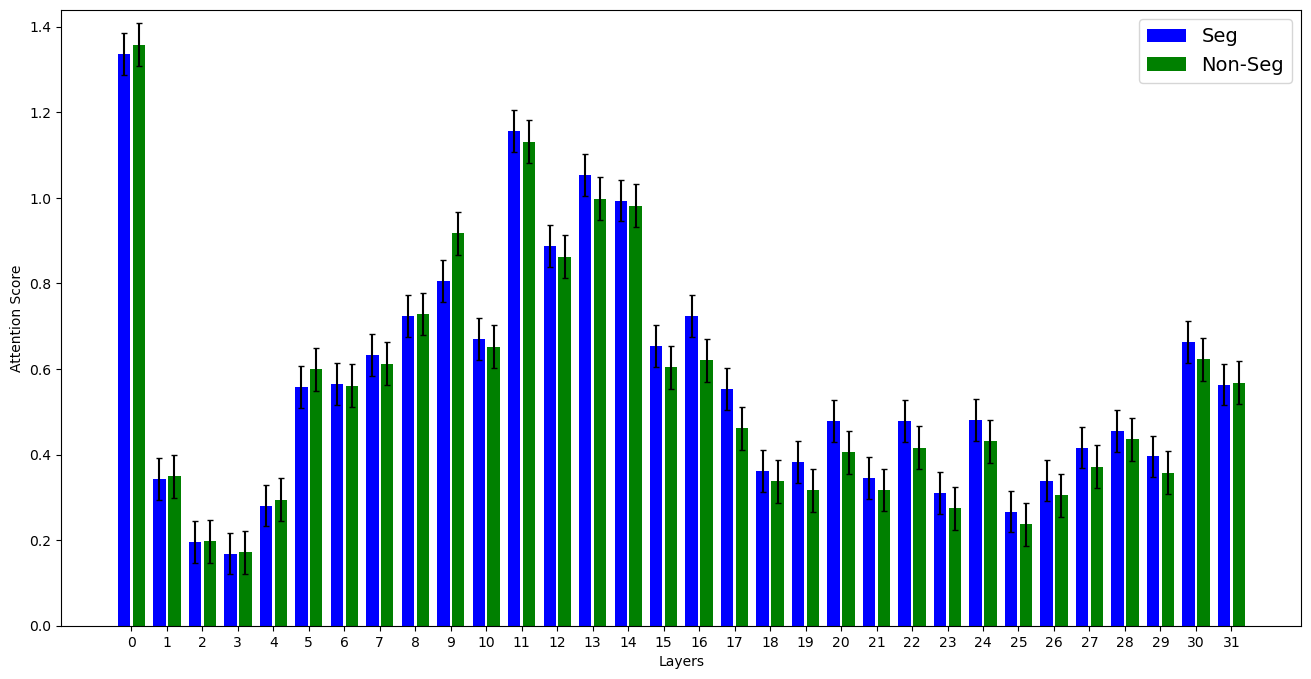

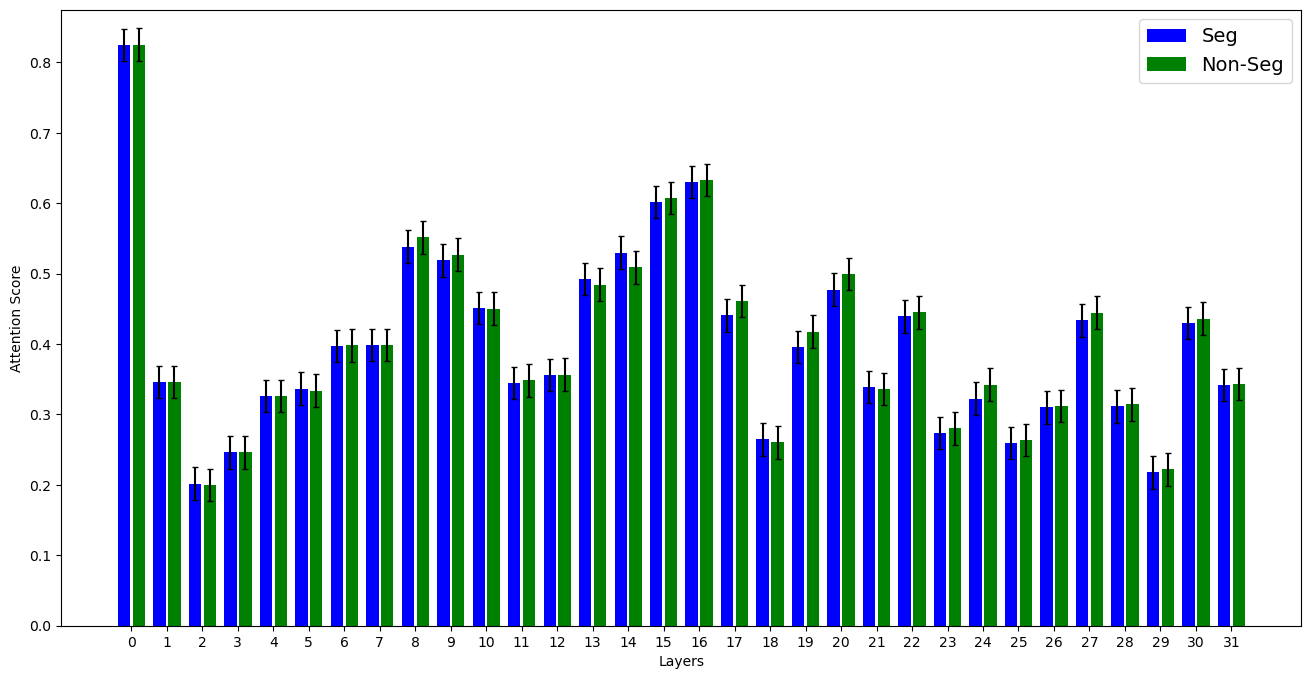

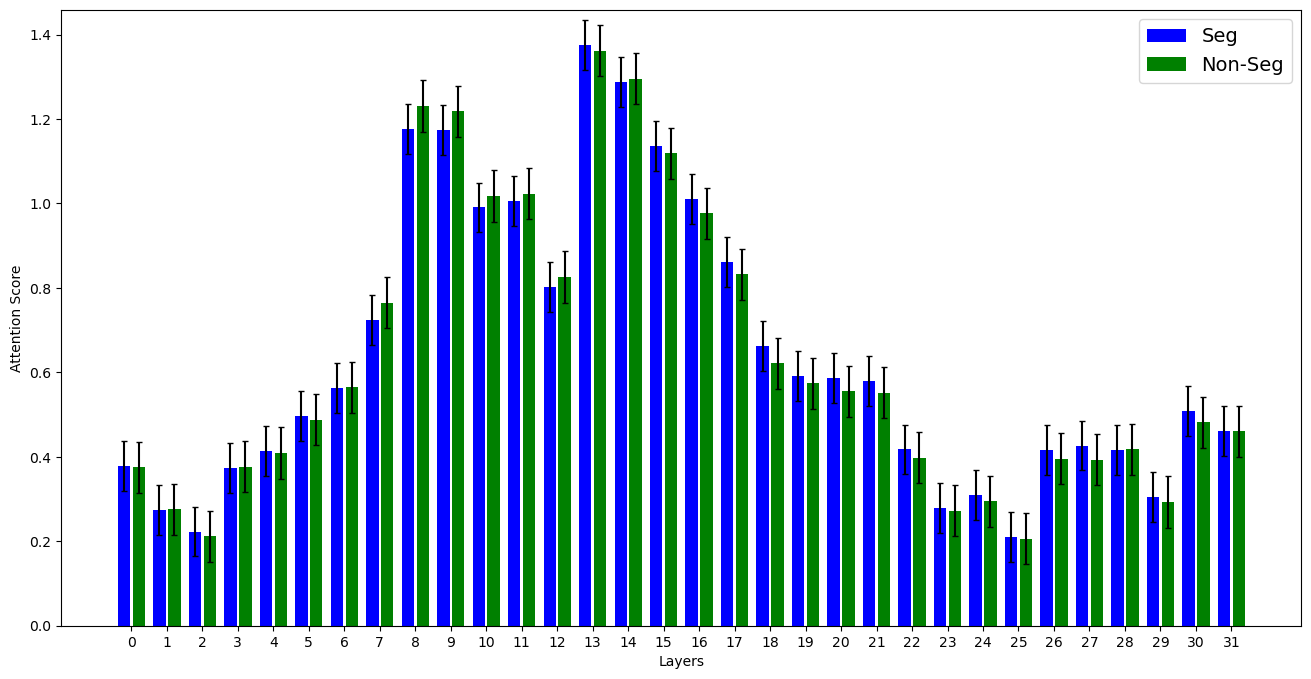

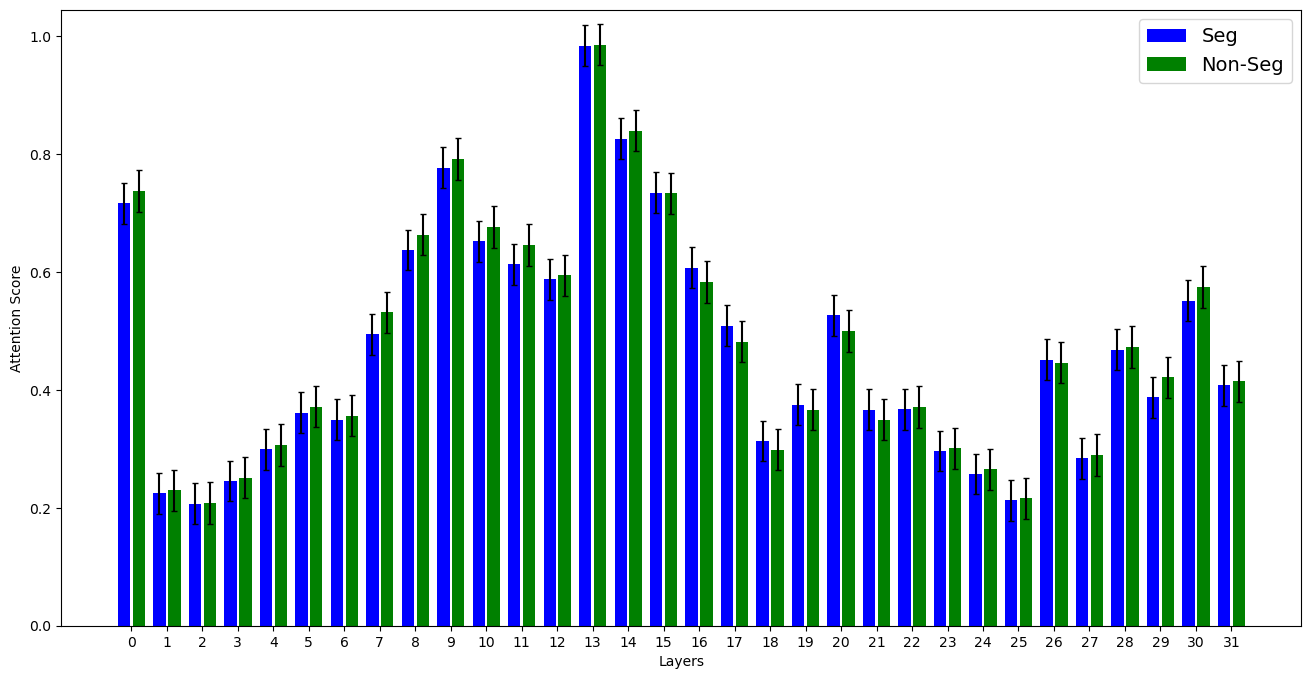

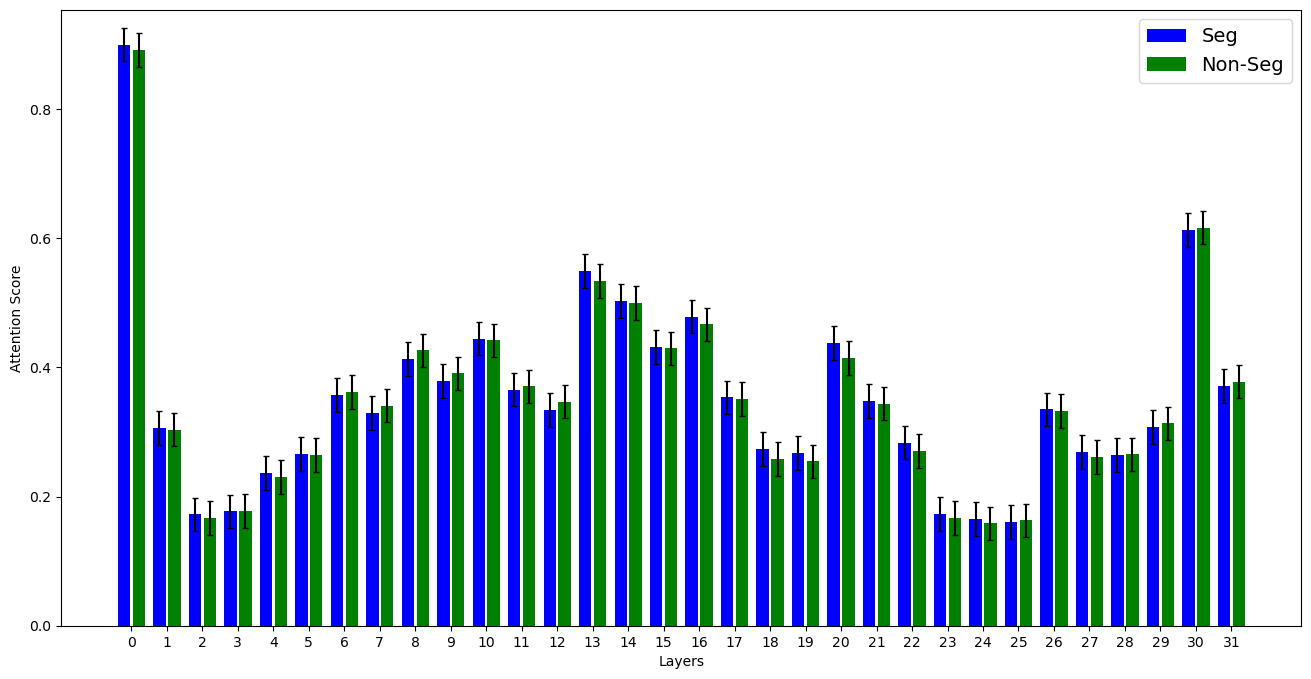

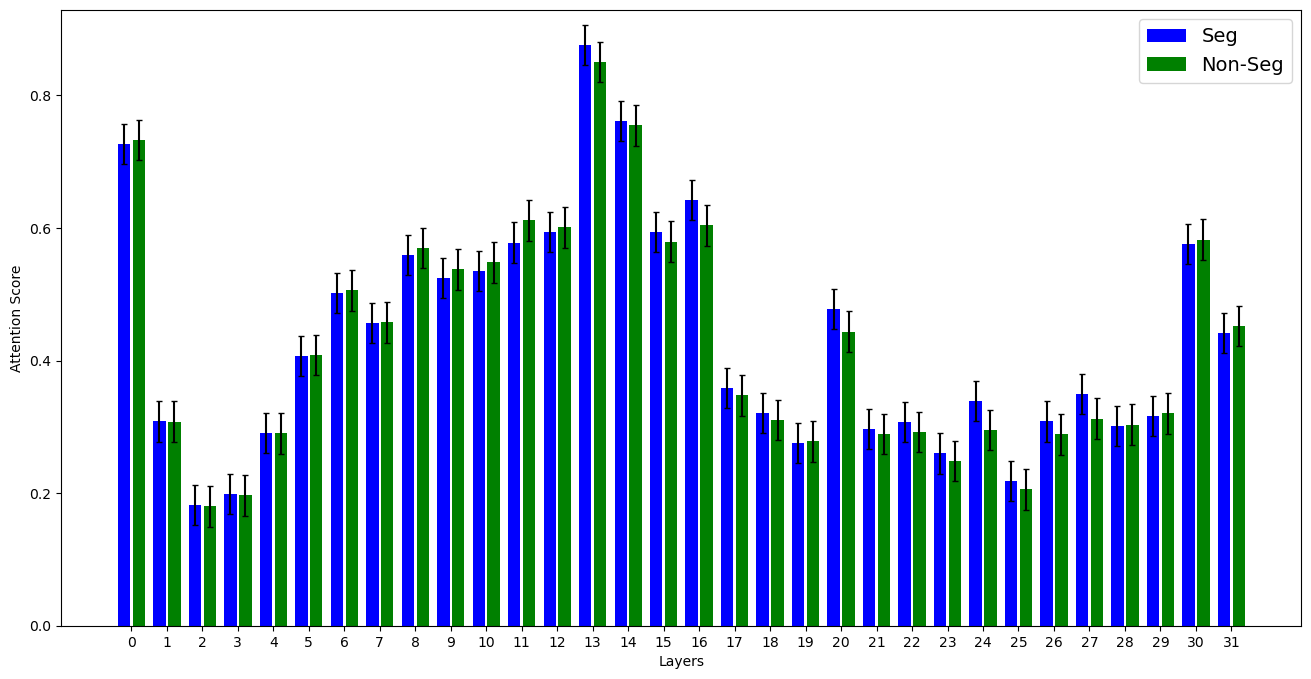

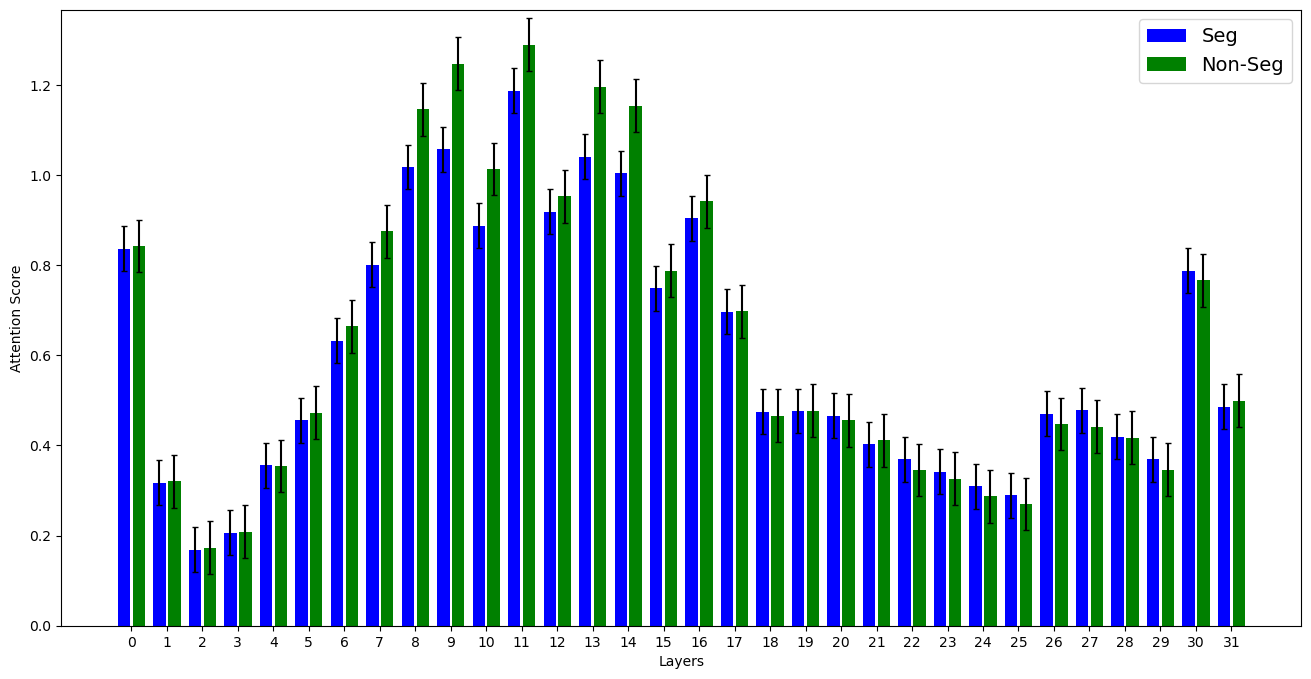

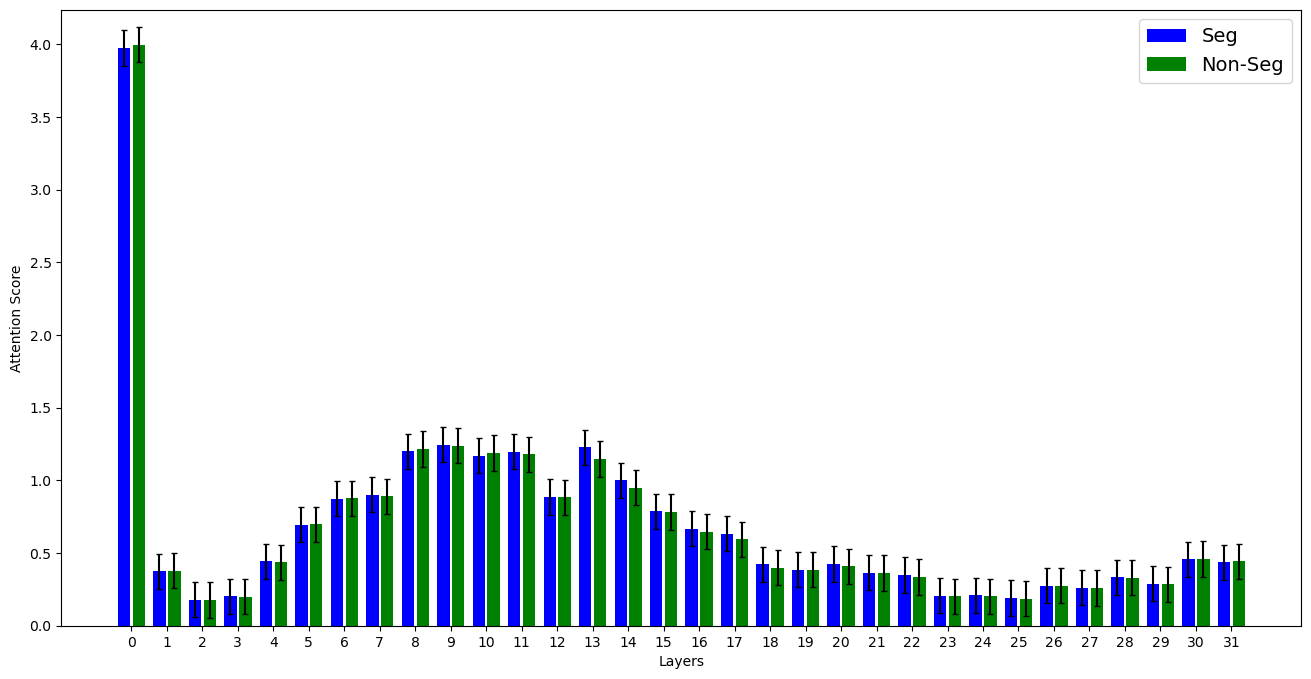

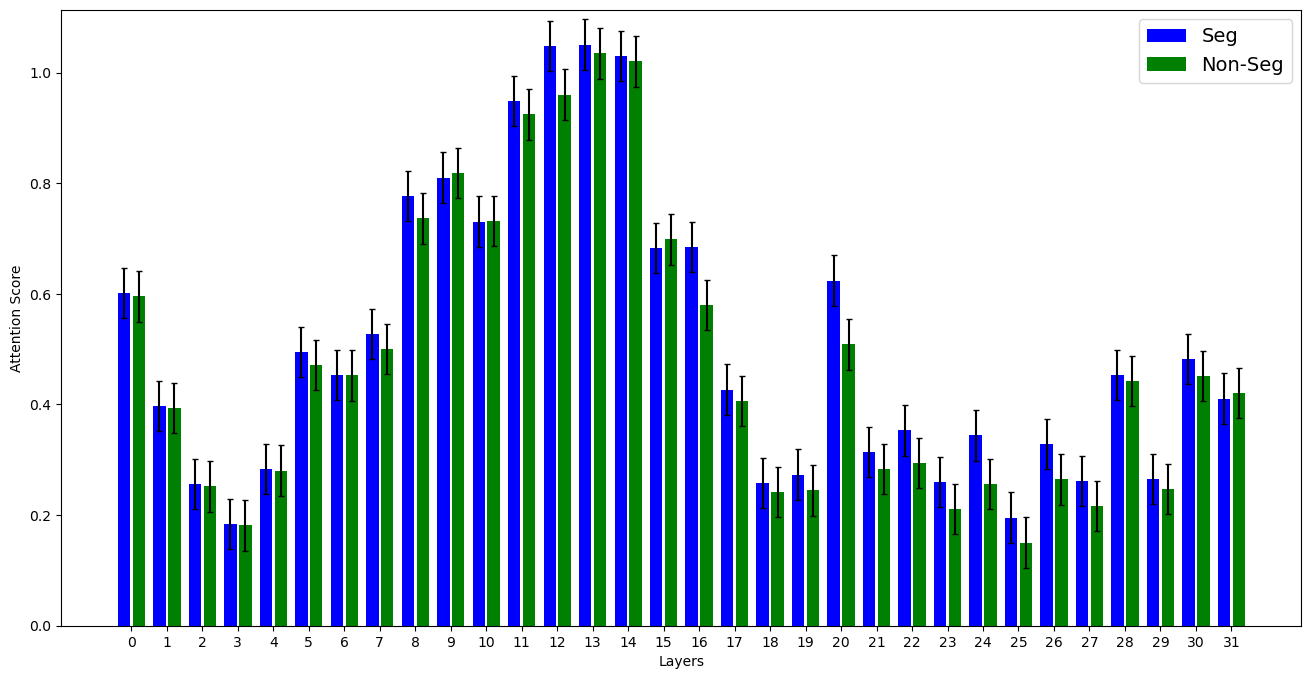

Data for POS tag SYM is missing for either 'seg' or 'noseg' condition.


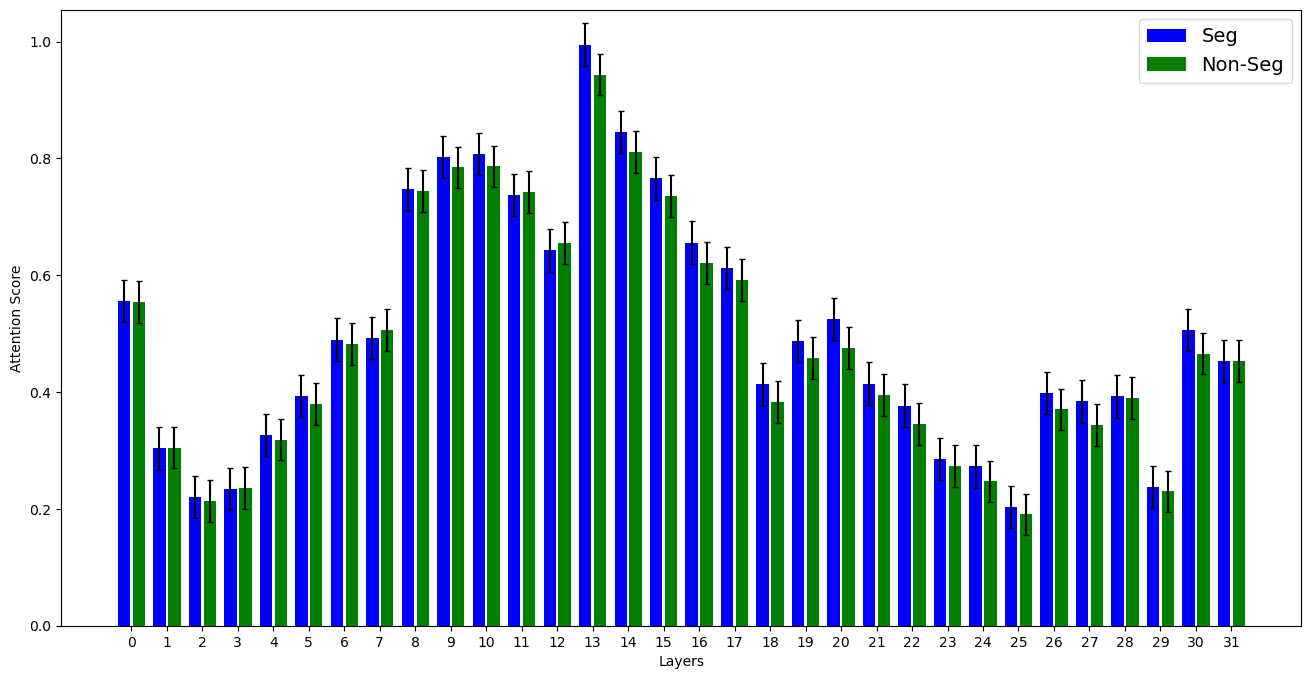

Data for POS tag X is missing for either 'seg' or 'noseg' condition.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Example of how to access the final averaged results
for pos_tag in pos_tags:
    # Retrieve the data for both conditions
    seg_key = (pos_tag, 'seg')
    noseg_key = (pos_tag, 'noseg')
    
    if seg_key in final_results_layer_ave and noseg_key in final_results_layer_ave:
        seg_data = final_results_layer_ave[seg_key]
        noseg_data = final_results_layer_ave[noseg_key]

        # Calculate SEM for seg and noseg conditions
        seg_sem = np.std(seg_data) / np.sqrt(len(seg_data))
        noseg_sem = np.std(noseg_data) / np.sqrt(len(noseg_data))
        
        # Determine the maximum y-axis value to keep the same scale
        max_y_value = max(np.max(seg_data), np.max(noseg_data))

        # Create a single plot with two sets of bars for each condition
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Define width of each bar
        bar_width = 0.35
        bar_dis = bar_width*.1
        
        # Define the positions of the bars
        indices = np.arange(len(seg_data))
        
        # Plot for 'seg' condition
        bars_seg = ax.bar(indices - bar_width/2 - bar_dis, seg_data, bar_width, label='Seg', color='blue',yerr=seg_sem, capsize=2)
        
        # Plot for 'noseg' condition
        bars_noseg = ax.bar(indices + bar_width/2 + bar_dis, noseg_data, bar_width, label='Non-Seg', color='green',yerr=noseg_sem, capsize=2)
        
        # Add labels 
        ax.set_xlabel("Layers")
        ax.set_ylabel("Attention Score")
        ax.set_ylim(0, max_y_value*1.06)  # Increase the limit slightly for label space
        ax.set_xticks(indices)
        ax.set_xticklabels([f'{i}' for i in indices])  

        # Add legend to clarify the conditions
        ax.legend(fontsize=14)
        
        # Save the plot
        plot_filename = f'layer_ave_comp_{pos_tag}.png'
        plt.savefig(os.path.join(plot_dir, plot_filename))
        
        plt.show()

    else:
        print(f"Data for POS tag {pos_tag} is missing for either 'seg' or 'noseg' condition.")


## A.2 Attention distribution for each POS tag: across all the layers and attention heads figure

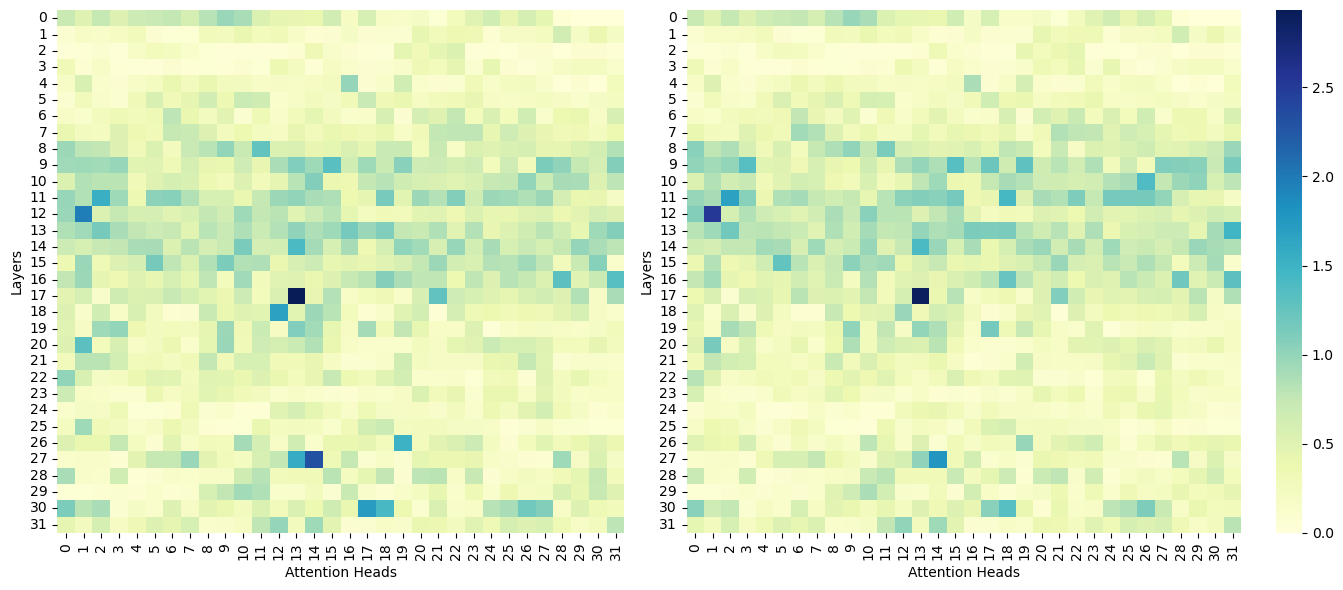

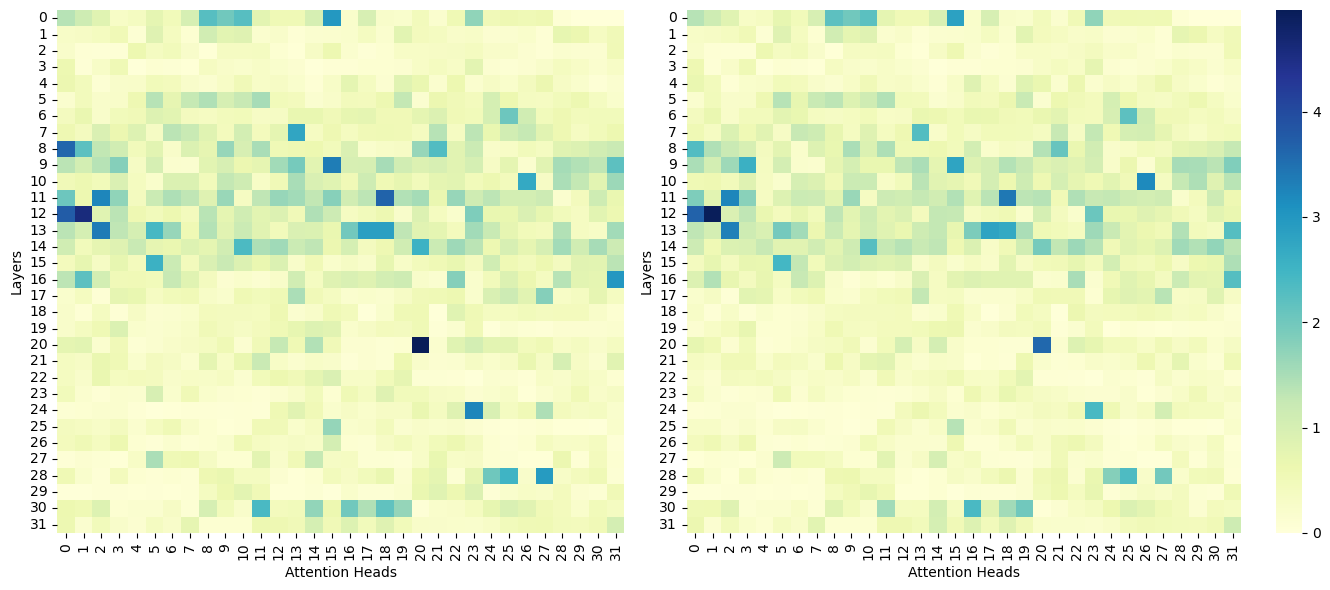

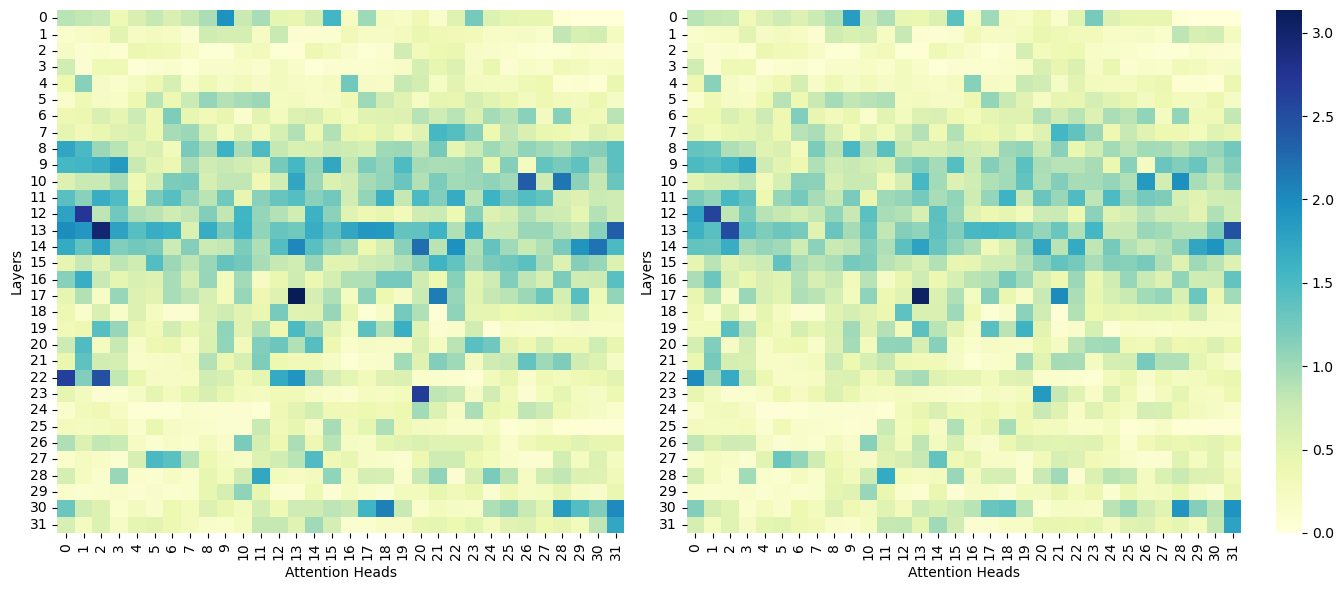

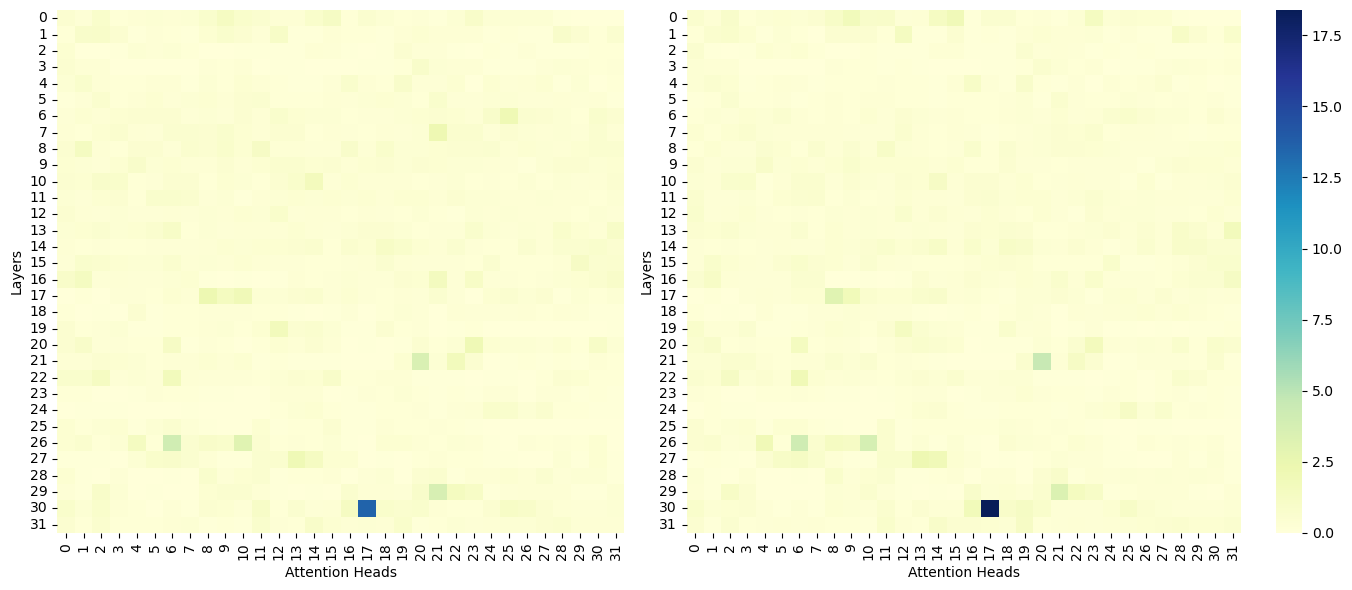

Data for POS tag CCONJ is missing for either 'seg' or 'noseg' condition.


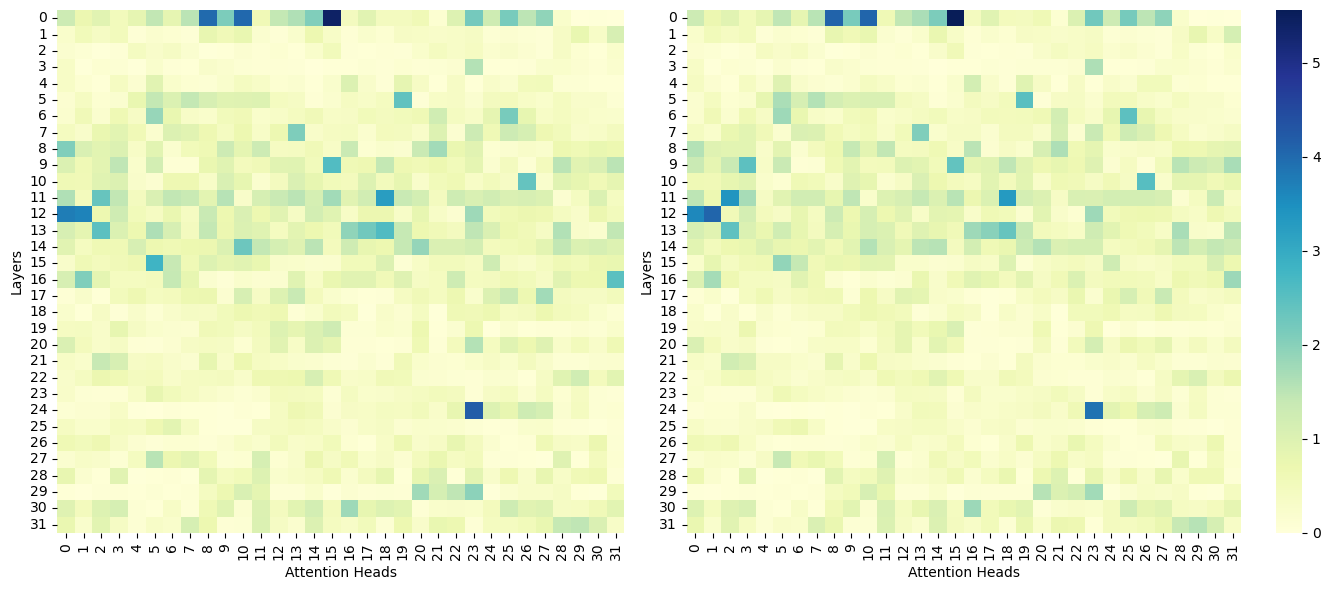

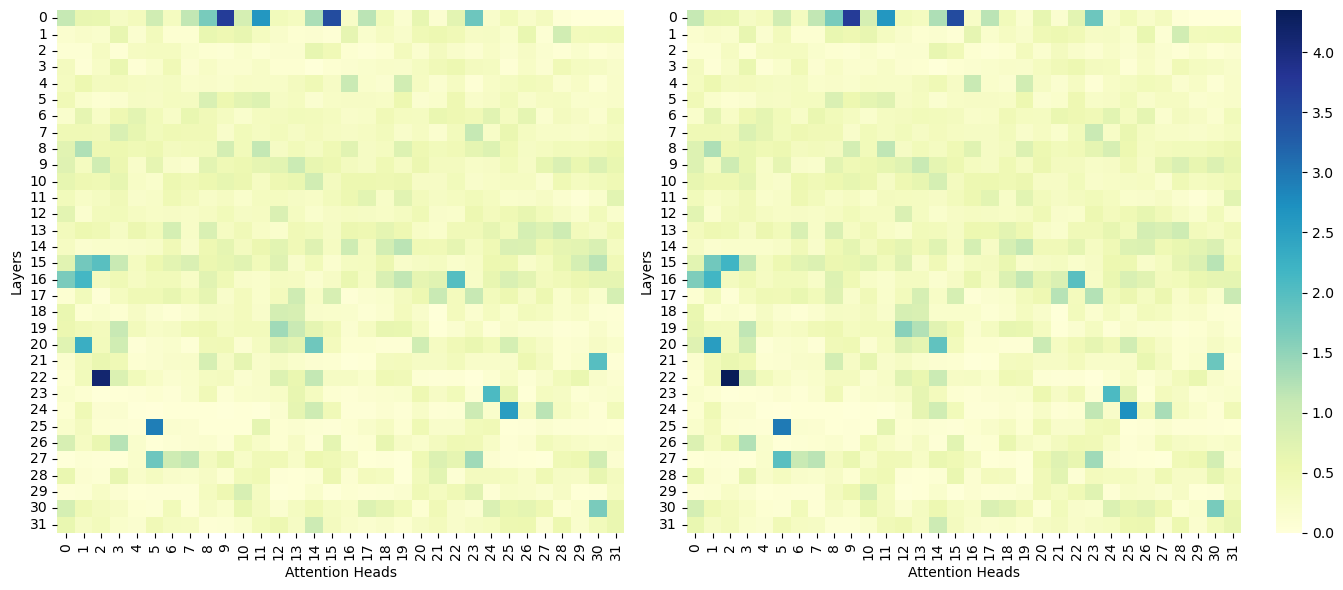

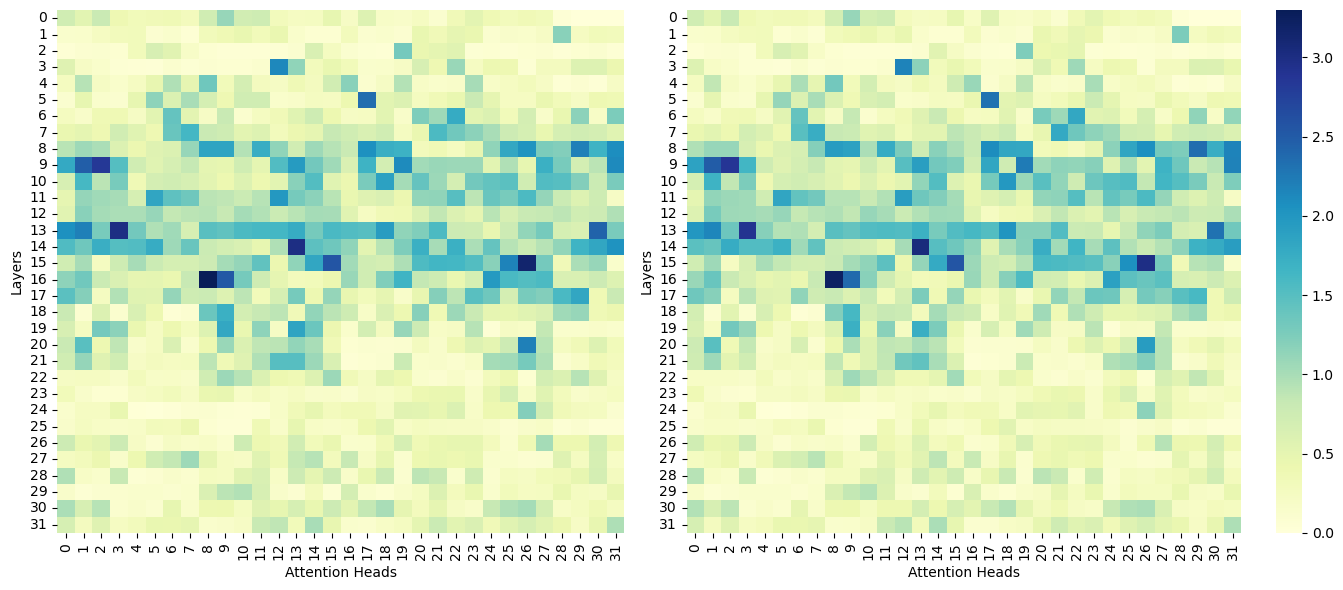

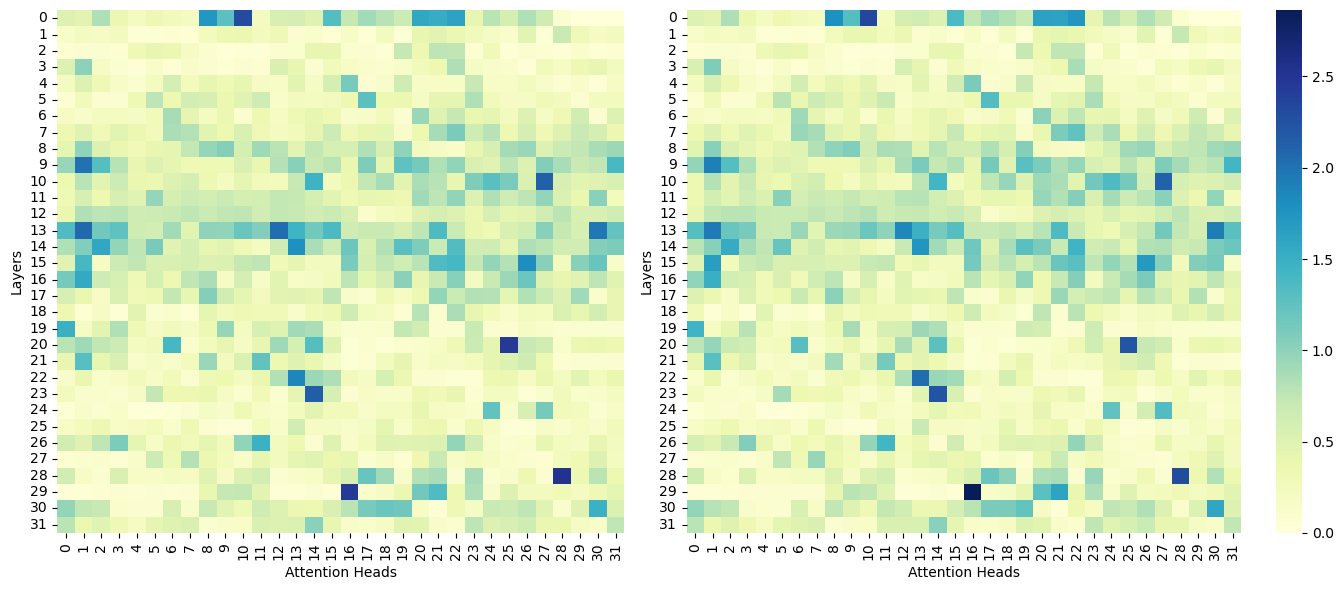

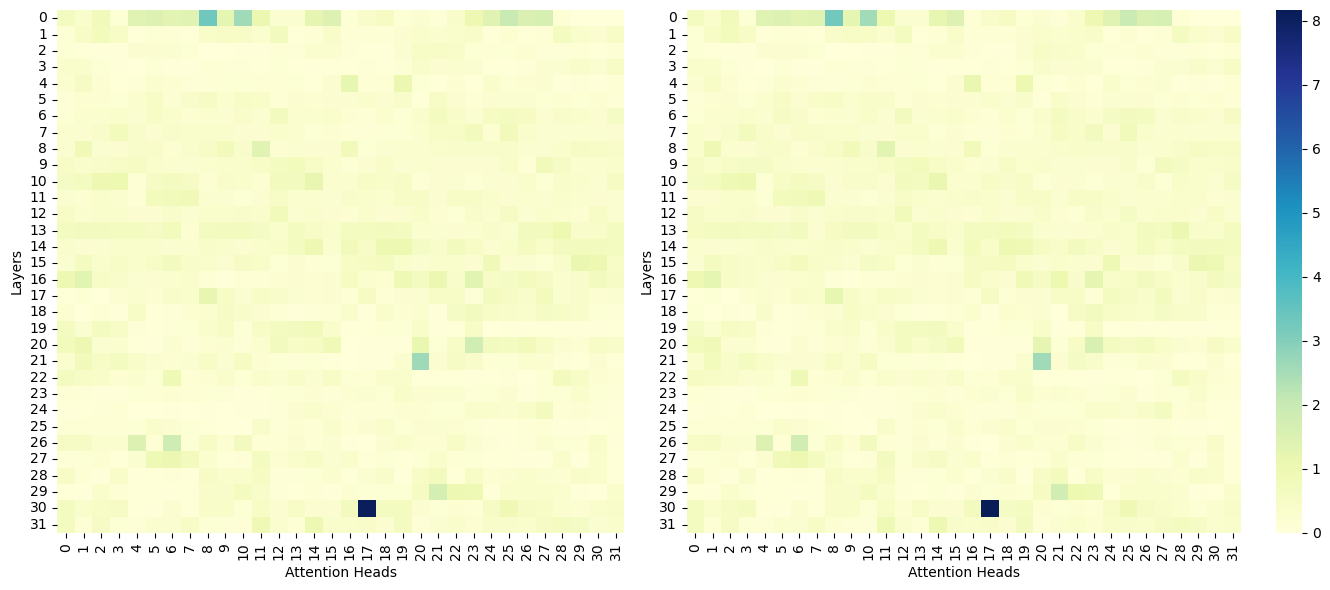

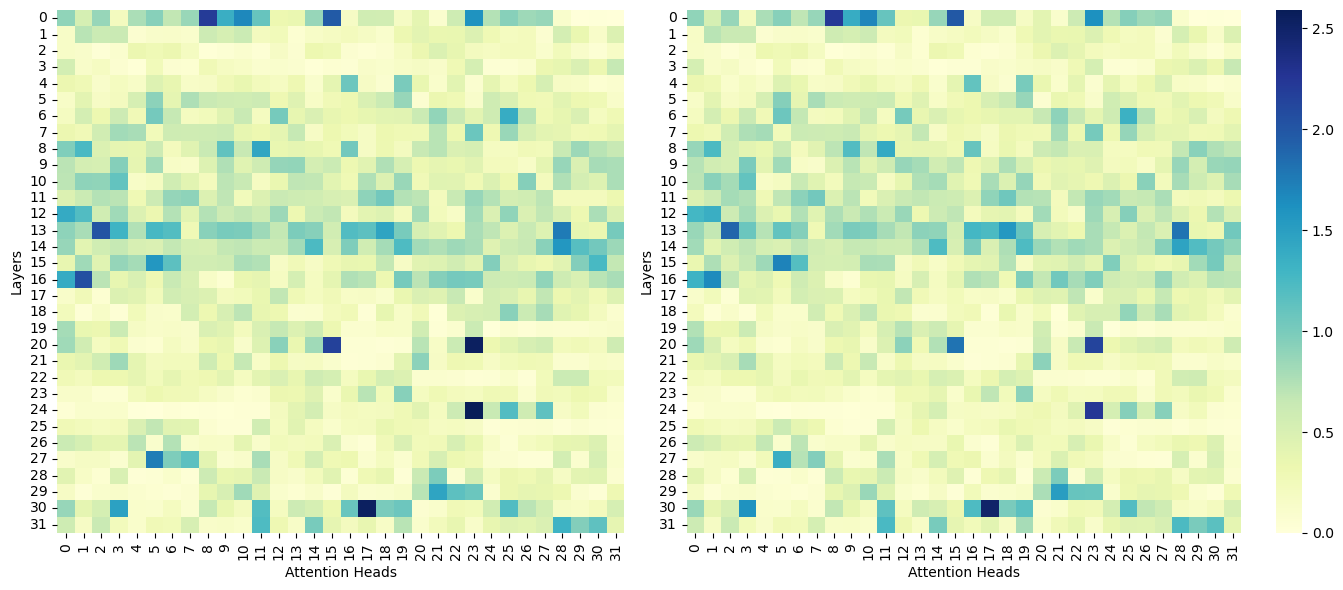

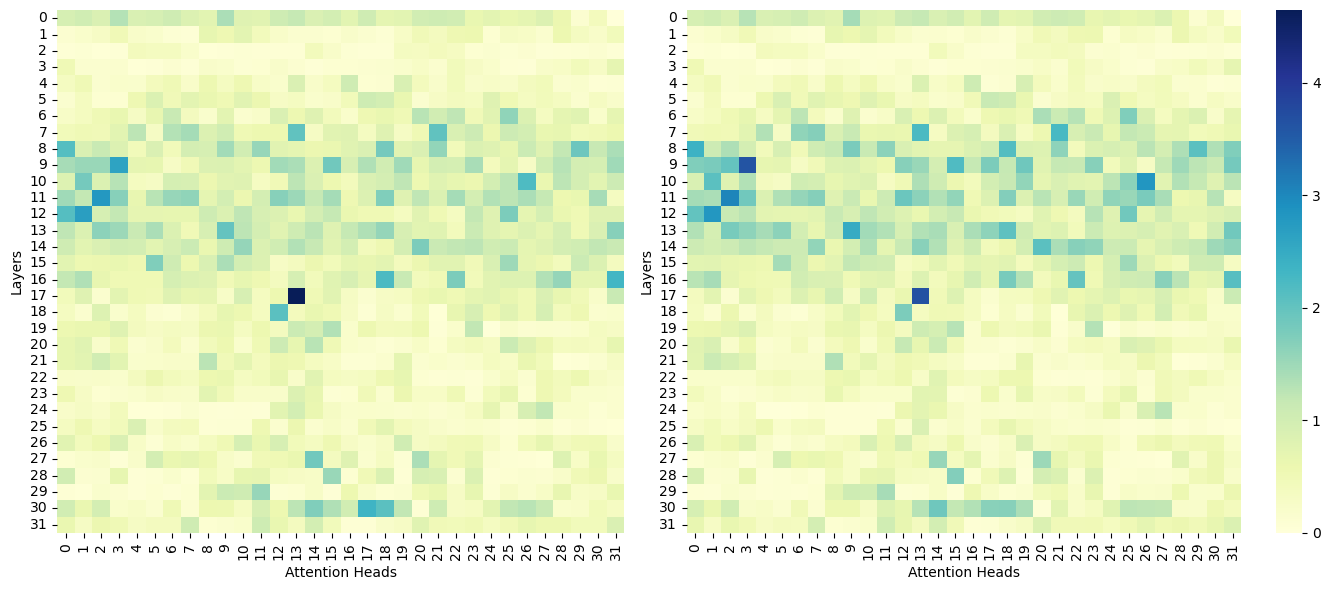

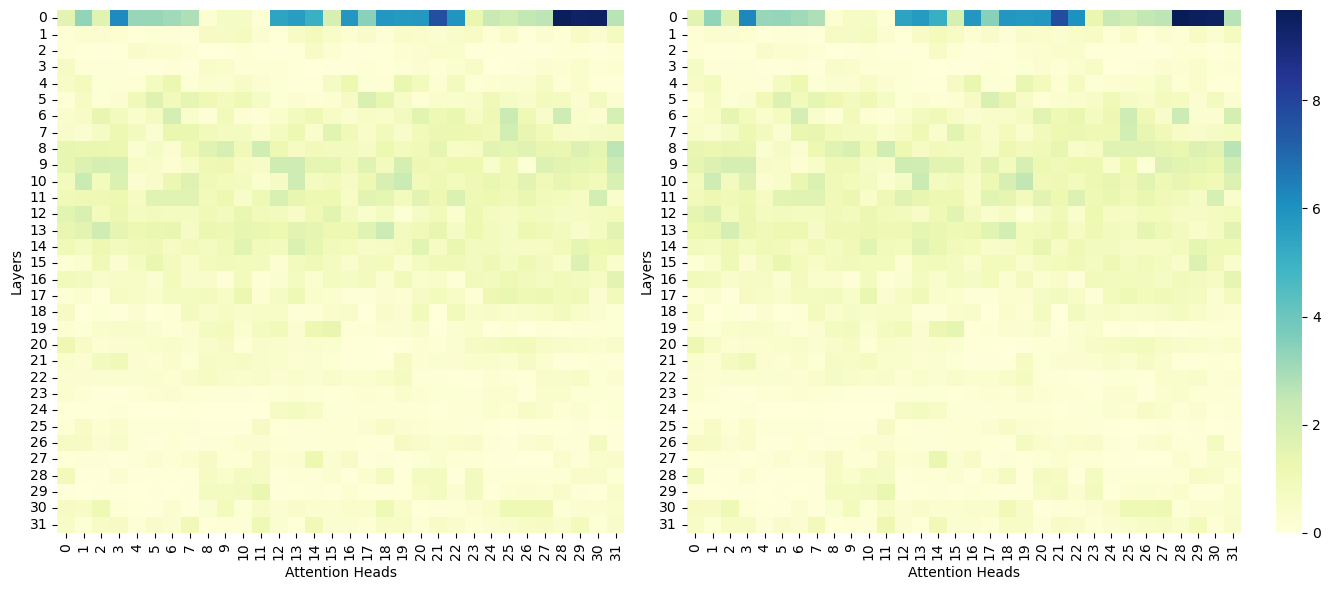

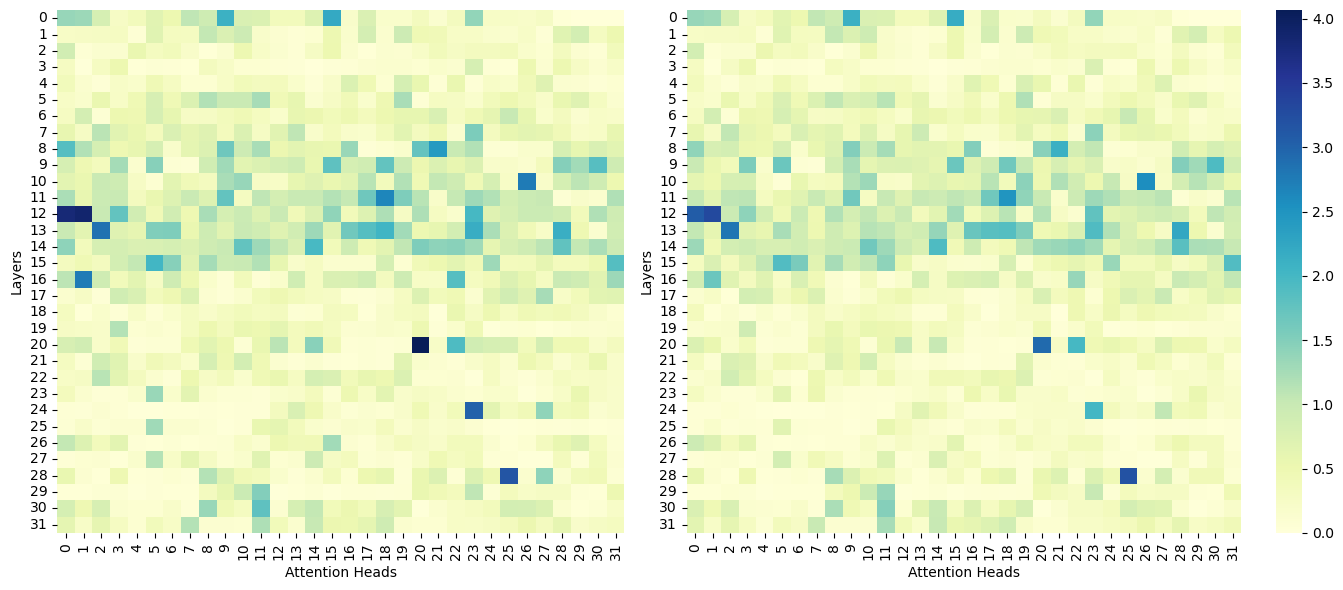

Data for POS tag SYM is missing for either 'seg' or 'noseg' condition.


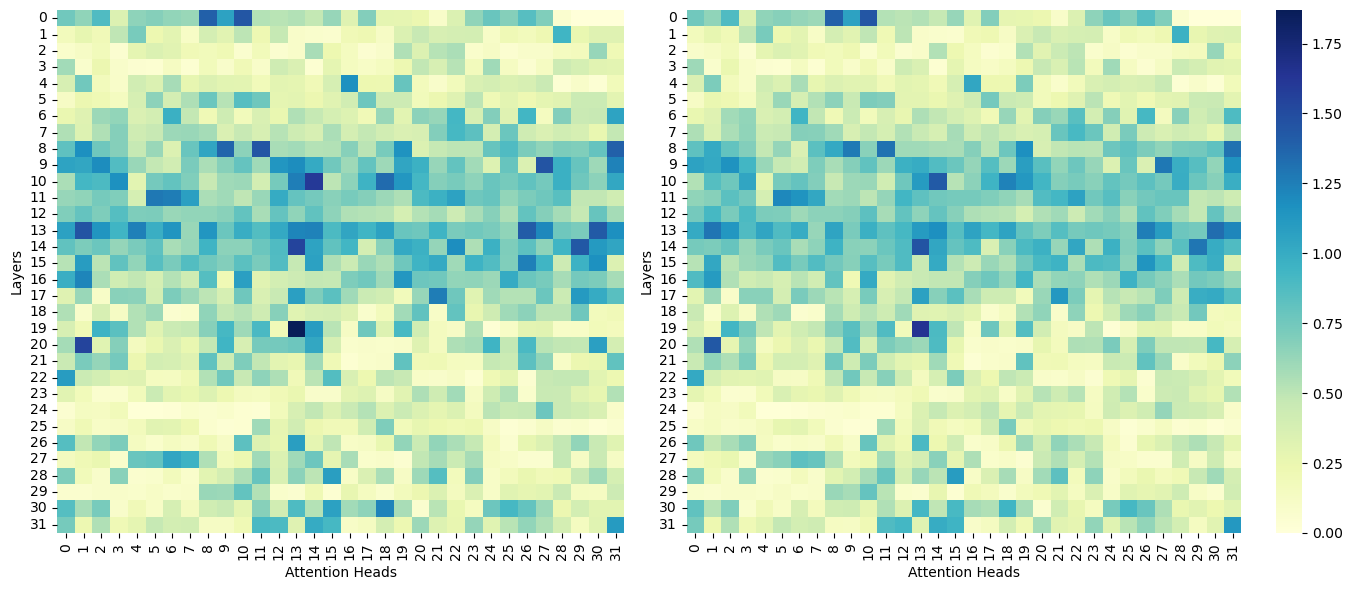

Data for POS tag X is missing for either 'seg' or 'noseg' condition.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example of how to access the final averaged results
for pos_tag in pos_tags:
    # Retrieve the data for both conditions
    seg_key = (pos_tag, 'seg')
    noseg_key = (pos_tag, 'noseg')
    
    if seg_key in final_results_all_attention and noseg_key in final_results_all_attention:
        seg_data = final_results_all_attention[seg_key]
        noseg_data = final_results_all_attention[noseg_key]
        
        # Determine the maximum value to keep the same heatmap scale
        max_value = max(np.max(seg_data), np.max(noseg_data))

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [0.9, 1.1]})

        # Plot heatmap for 'seg' condition
        sns.heatmap(seg_data, annot=False, cmap="YlGnBu", cbar=False, ax=axes[0],
                    vmin=0, vmax=max_value,
                    xticklabels=[f'{i}' for i in range(32)],
                    yticklabels=[f'{i}' for i in range(32)])
        #axes[0].set_title(f'{pos_tag} Seg Attention Heatmap')
        axes[0].set_xlabel("Attention Heads")
        axes[0].set_ylabel("Layers")

        # Plot heatmap for 'noseg' condition
        sns.heatmap(noseg_data, annot=False, cmap="YlGnBu", cbar=True, ax=axes[1],
                    vmin=0, vmax=max_value,
                    xticklabels=[f'{i}' for i in range(32)],
                    yticklabels=[f'{i}' for i in range(32)])
        #axes[1].set_title(f'{pos_tag} Non-seg Attention Heatmap')
        axes[1].set_xlabel("Attention Heads")
        axes[1].set_ylabel("Layers")

        # Adjust layout and show plot
        plt.tight_layout()

        # Save the plot
        plot_filename = f'layer_head_{pos_tag}.png'
        plt.savefig(os.path.join(plot_dir, plot_filename))
        
        plt.show()
    else:
        print(f"Data for POS tag {pos_tag} is missing for either 'seg' or 'noseg' condition.")


## A.4 POS tag attention Figure

Data for POS tag CCONJ is missing for either 'seg' or 'noseg' condition.
Data for POS tag SYM is missing for either 'seg' or 'noseg' condition.
Data for POS tag X is missing for either 'seg' or 'noseg' condition.
Pairwise t-test results: t-statistic = 1.957679917732777, p-value = 0.07208565066138309


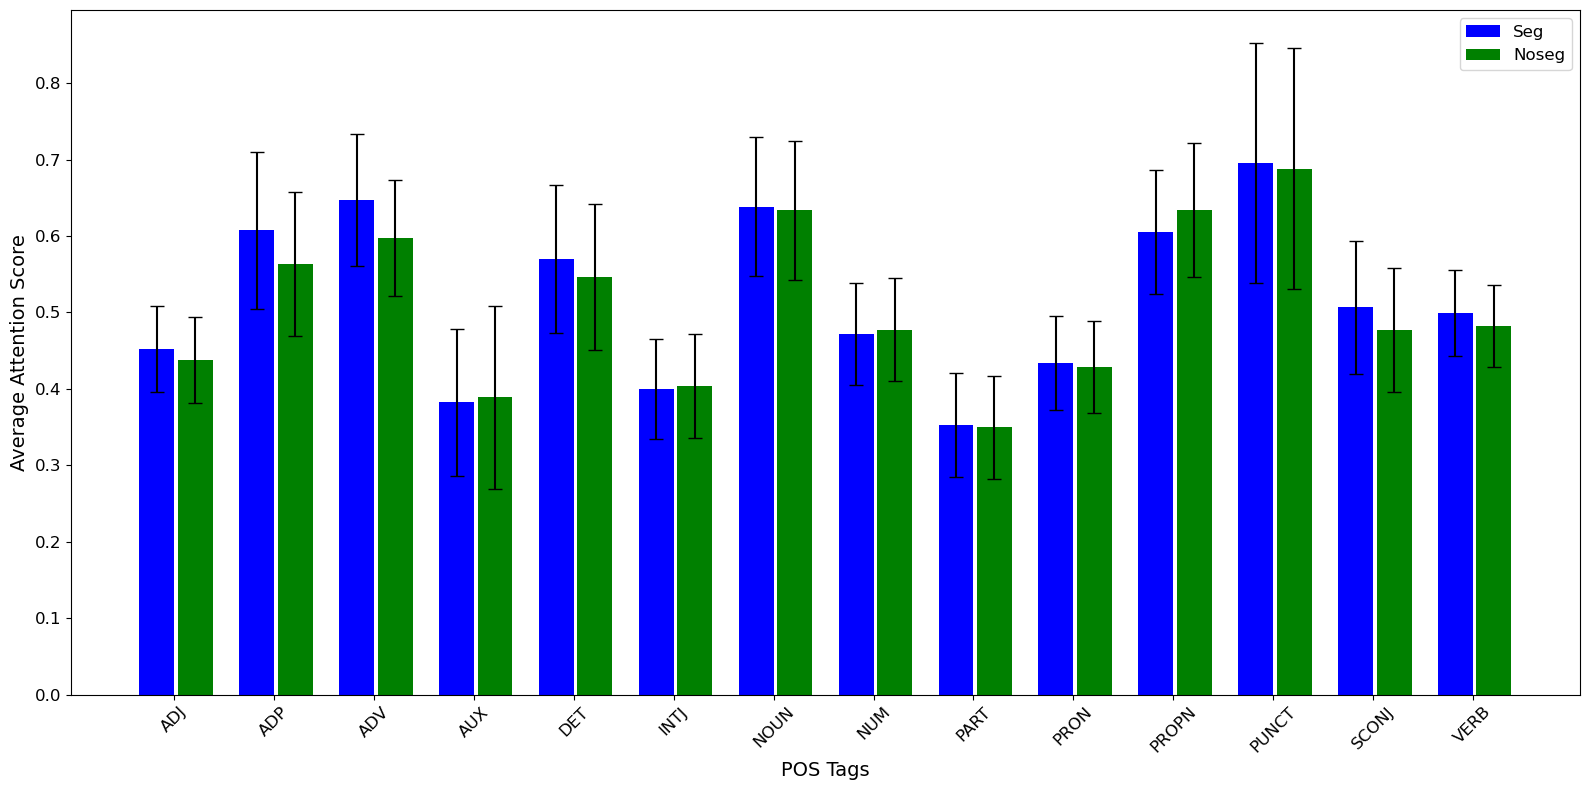

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming you have the following variables already defined:
# pos_tags: list of all POS tags
# final_results_all_attention: dictionary containing attention data
# result_path: base path where results are stored
# stories: list of story identifiers

# Initialize dictionaries to store average attention values for each pos_tag
pos_tag_attention_avg = {}

# Lists to store valid POS tags and their corresponding averages
valid_pos_tags = []
seg_avgs = []
noseg_avgs = []
seg_sem = []
noseg_sem = []

# Iterate over each POS tag
for pos_tag in pos_tags:
    seg_key = (pos_tag, 'seg')
    noseg_key = (pos_tag, 'noseg')
    
    if seg_key in final_results_all_attention and noseg_key in final_results_all_attention:
        seg_data = final_results_all_attention[seg_key]
        noseg_data = final_results_all_attention[noseg_key]
        
        # Calculate the average attention values across stories, layers, and heads
        avg_seg_attention = np.mean(seg_data)
        avg_noseg_attention = np.mean(noseg_data)

        # Calculate standard error of the mean (SEM)
        sem_seg_attention = np.std(seg_data) / np.sqrt(len(seg_data))
        sem_noseg_attention = np.std(noseg_data) / np.sqrt(len(noseg_data))
        
        # Store the results
        pos_tag_attention_avg[pos_tag] = {
            'seg_avg': avg_seg_attention,
            'noseg_avg': avg_noseg_attention
        }
        
        # Append to lists for plotting
        valid_pos_tags.append(pos_tag)
        seg_avgs.append(avg_seg_attention)
        noseg_avgs.append(avg_noseg_attention)
        seg_sem.append(sem_seg_attention)
        noseg_sem.append(sem_noseg_attention)
        
    else:
        print(f"Data for POS tag {pos_tag} is missing for either 'seg' or 'noseg' condition.")

# Perform pairwise t-test between seg_avgs and noseg_avgs
t_stat, p_value = ttest_rel(seg_avgs, noseg_avgs)

# Print the result
print(f"Pairwise t-test results: t-statistic = {t_stat}, p-value = {p_value}")

# Check if there is data to plot
if len(valid_pos_tags) == 0:
    print("No valid POS tags with complete data found. Cannot generate plot.")
else:
    # Set up plot parameters
    bar_width = 0.35
    bar_dis = bar_width*.1
    index = np.arange(len(valid_pos_tags))
    
    plt.figure(figsize=(16, 8))
    
    # Plotting the bars
    plt.bar(index, seg_avgs, bar_width, color='blue', label='Seg',yerr=seg_sem, capsize=5)
    plt.bar(index + bar_width+bar_dis, noseg_avgs, bar_width, color='green', label='Noseg', yerr=noseg_sem, capsize=5)
    
    # Adding value labels on top of each error bar
    #for i in range(len(index)):
    #    plt.text(index[i] -bar_dis*2, seg_avgs[i] + seg_sem[i]+ 0.002, f'{seg_avgs[i]:.4}', ha='center', va='bottom', fontsize=10)
    #    plt.text(index[i] + bar_width + bar_dis*2, noseg_avgs[i] + noseg_sem[i] + 0.002, f'{noseg_avgs[i]:.4f}', ha='center', va='bottom', fontsize=10)
    
    # Setting labels and title
    plt.xlabel('POS Tags', fontsize=14)
    plt.ylabel('Average Attention Score', fontsize=14)
    #plt.title('Average Attention Score by POS Tag and Segmentation Condition', fontsize=16)
    plt.xticks(index + bar_width / 2, valid_pos_tags, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f'hist_ave_{pos_tag}.png'
    plt.savefig(os.path.join(plot_dir, plot_filename))

    plt.show()